<a href="https://colab.research.google.com/github//asabenhur/CS425/blob/master/notebooks/06_clustering_proteins.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Clustering protein sequences

The objective of this notebook is to compute a similarity matrix that will useful for clustering protein sequences and ordering the sequences for creating a multiple sequence alignment.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Sequence similarity computed using shared k-mers

Your first task is to write code that computes sequence similarity using shared k-mers.
We define

$$\mathrm{sim}(s1, s2, k) = \sum_{\mathrm{kmer \in s1}} \min(\mathrm{counts}(kmer, s1), \mathrm{counts}(kmer, s2) ),$$

where $s1,s2$ are two protein sequences, $k$ is the kmer length and $\mathrm{counts}(kmer, s)$ is the number of times the given kmer appears in the sequence $s$.

For example, if 

s1 = `ACGTATACACGTAT` and s2 = `TATCGGTATATCCTAC` we have 

$$\mathrm{sim}(s1, s2, 3) = 1 + 1 + 1 + 2 = 5$$

Because of the shared kmers `ATA`, `TAC`, `TAT`, and `GTA`.

This measure of similarity is then normalized to be between 0 and 1:

$$\mathrm{sim}_{norm}(s1, s2, k) = \frac{\mathrm{sim}(s1, s2, k)}{\max( \mathrm{sim}(s1, s1, k), \mathrm{sim}(s2, s2, k) }$$

For your convenience here is my parser for fasta files:

In [2]:
"""
A parser for FASTA files.

It can handle files that are local or on the web.
Gzipped files do not need to be unzipped.
"""

import os
from urllib.request import urlopen

def myopen(fileName) :

    if not ( os.path.exists(fileName) and os.path.isfile(fileName) ):
        raise ValueError('file does not exist at %s' % fileName)
    
    import gzip
    fileHandle = gzip.GzipFile(fileName)

    gzippedFile = True
    try :
        line = fileHandle.readline()
        fileHandle.close()
    except :
        gzippedFile = False

    if gzippedFile :
        return gzip.GzipFile(fileName)
    else :
        return open(fileName)


class MalformedInput :
    "Exception raised when the input file does not look like a fasta file."
    pass

class FastaRecord :
    """Represents a record in a fasta file."""
    def __init__(self, header, sequence):
        """Create a record with the given header and sequence."""
        self.header = header
        self.sequence = sequence
    def __str__(self) :
        return '>' + self.header + '\n' + self.sequence + '\n'

    
def _fasta_itr_from_file(file_handle) :
    "Provide an iteration through the fasta records in file."

    h = file_handle.readline()[:-1]
    if h[0] != '>':
        raise MalformedInput()
    h = h[1:]

    seq = []
    for line in file_handle:
        line = line[:-1] # remove newline
        if line[0] == '>':
            yield FastaRecord(h,''.join(seq))
            h = line[1:]
            seq = []
            continue
        seq.append(line)

    yield FastaRecord(h,''.join(seq))

        
def _fasta_itr_from_web(file_handle) :
    "Iterate through a fasta file posted on the web."

    h = file_handle.readline().decode("utf-8")[:-1]
    if h[0] != '>':
        raise MalformedInput()
    h = h[1:]

    seq = []
    for line in file_handle:
        line = line.decode("utf-8")[:-1] # remove newline
        if line[0] == '>':
            yield FastaRecord(h,''.join(seq))
            h = line[1:]
            seq = []
            continue
        seq.append(line)

    yield FastaRecord(h,''.join(seq))



def _fasta_itr_from_name(fname):
    "Iterate through a fasta file with the given name."

    f = myopen(fname)
    for rec in _fasta_itr_from_file(f) :
        yield rec


def _fasta_itr(src):
    """Provide an iteration through the fasta records in file `src'.
    
    Here `src' can be either a file name or a url of a file.
    """
    if type(src) == str :
        if src.find("http")>=0 :
            file_handle = urlopen(src)
            return _fasta_itr_from_web(file_handle)
        else :
            return _fasta_itr_from_name(src)
    else:
        raise TypeError

    
class fasta_itr (object) :
    """An iterator through a Fasta file"""

    def __init__(self, src) :
        """Create an iterator through the records in src."""
        self.__itr = _fasta_itr(src)

    def __iter__(self) :
        return self

    def __next__(self) :
        return self.__itr.__next__()



For our analysis we'll read a collection of sequence that represent globin-like proteins (hemoglobin, and myoglobin):

In [3]:
fasta_url = "https://raw.githubusercontent.com/asabenhur/CS425/main/data/globins.fasta"
sequences = [record.sequence for record in fasta_itr(fasta_url)]

In [4]:
len(sequences)

136

Using these sequences compute a matrix of similarities that stores the similarity between all pairs of sequences.  I suggest splitting the code into two functions:

In [5]:
def kmer_similarity(seq1, seq2, k) :
    """Returns the k-mer normalized similarity between
    two sequences as described above.  s1 and s2 are the two 
    sequences, and k is the k-mer length."""
    return 0.0

In [6]:
def similarity_matrix(sequences, k) :
    """Compute the similarity matrix for a list of sequences
    with a k-mer length of k"""
    return np.zeros((len(sequences), len(sequences)),np.float)
    

Let's use the following code-snippet to visualize the matrix of similarities:

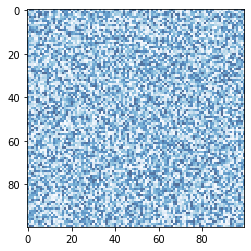

In [8]:
# first compute the matrix of similarities.  This assumes that
# the variable sim is a square matrix.
# for show, I am using a matrix with random numbers:
from numpy.random import default_rng
rng = default_rng()
sim = rng.uniform(size=(100, 100))
plt.imshow(sim, cmap="Blues", alpha=0.7);

### Question:

Explore the data for different values of $k$.  Which value or range of values seem to provide a useful result?
Comment on what you're seeing using this visualization.

*your answer here*

### Clustering the matrix

Next we will use the scikit-learn implementation of hierarchical clustering to compute a clustering of our data.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

First, we need to convert the matrix of similarities to dissimilarities, since that is what the scikit-learn code expects:

In [ ]:
dist = 1-sim

In [ ]:
clusterer = AgglomerativeClustering(
    affinity='precomputed', n_clusters=5, linkage='complete')
clusterer = clusterer.fit(dist)
clusterer.labels_

### Question:

Explore the various linkage functions described in the documentation of the scikit-learn documentation of the [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) class.  Which linkage function provides a result which best captures the cluster structure that you have observed in the visualization above?

*your answer here*